In [13]:
%load_ext autoreload
%autoreload 2
from superbit_lensing.plotter import ClusterRedSequenceAnalysis
from astropy.table import Table

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
cluster_name = 'Abell2345'
datadir = "/scratch/sa.saha/data" #Change to your data directory!
#datafilename = "home/filename.fits"
analyzer = ClusterRedSequenceAnalysis(cluster_name, datadir, delz=0.02, radius_th=0.5)
analyzer.load_data()

Galaxies with z > 0.20: 10
Galaxies with 0.16 < z ≤ 0.20: 79
Galaxies with z ≤ 0.16: 16


Number of objects in the red sequence: 1057
Saved red sequence analysis plot to: /projects/mccleary_group/saha/codes/superbit-lensing/notebooks/red_sequence/chandra_data/redseq.png


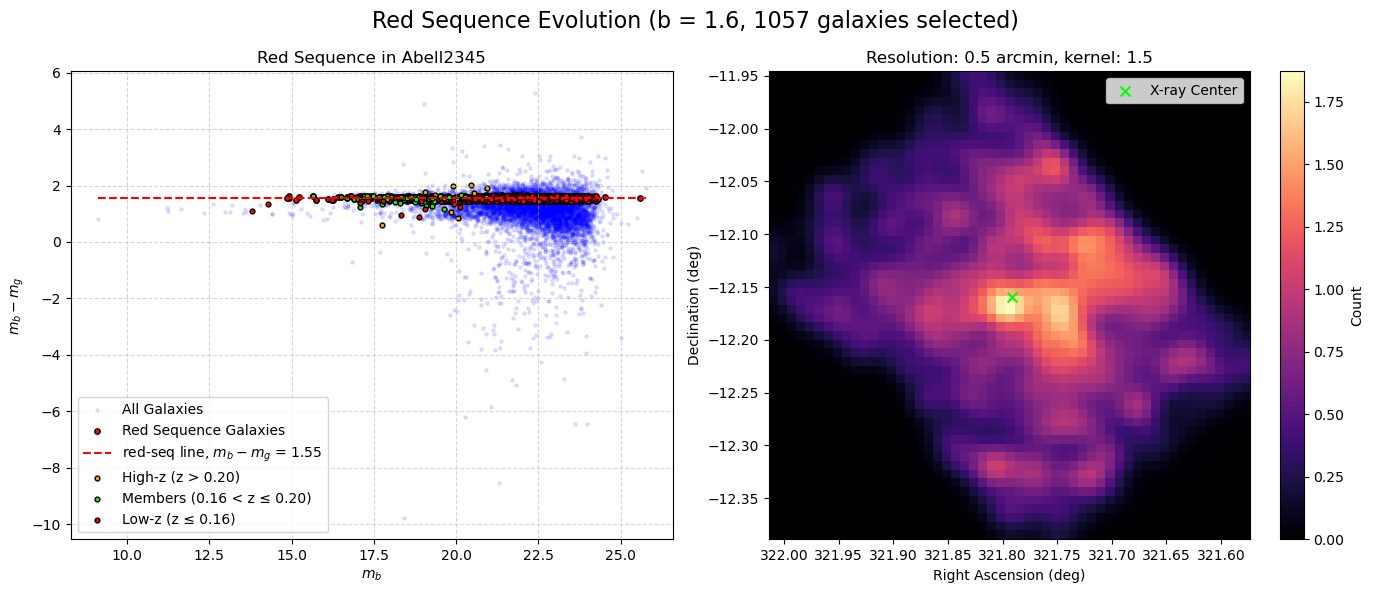

In [24]:
save_path = "/projects/mccleary_group/saha/codes/superbit-lensing/notebooks/red_sequence/chandra_data/redseq.png" #Define the path
analyzer.compute_red_sequence(a=0.0, b=1.55, tolerance=0.1, resolution=0.5, sigma=1.5, save_path=save_path)

Saved cluster member identification plot to: /projects/mccleary_group/saha/codes/superbit-lensing/notebooks/red_sequence/chandra_data/members.png


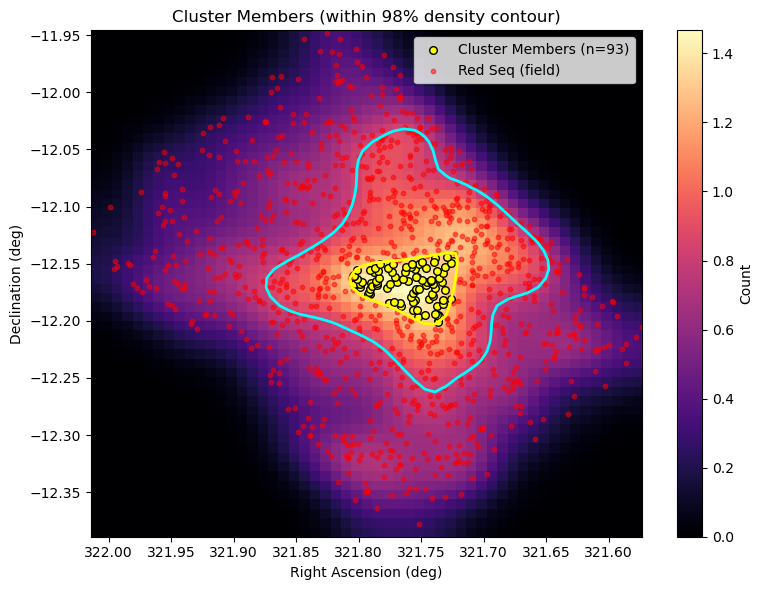


Cluster Member Selection Summary:
Total red sequence galaxies: 1057
Galaxies within cluster contour: 93
Fraction in cluster: 8.8%


In [25]:
save_path = "/projects/mccleary_group/saha/codes/superbit-lensing/notebooks/red_sequence/chandra_data/members.png" #Define the path
cluster_catalog = analyzer.identify_cluster_members(percentiles=[85, 98], sigma_smooth=2.5, save_path=save_path)

In [6]:
output_path = # f"{cluster_name}_coadd_redseq.fits"
file_name = # f"{cluster_name}_colors_mags.fits"
analyzer.save_cluster_catalog(output_path=output_path)
analyzer.update_original_catalog(file_name=file_name)

Saved cluster member catalog to: /projects/mccleary_group/saha/codes/superbit-lensing/notebooks/red_sequence/chandra_data/redseq.fits
Total cluster members saved: 93
Updated original catalog: /projects/mccleary_group/saha/codes/superbit-lensing/notebooks/red_sequence/chandra_data/Abell2345_colors_mags.fits
Total red sequence galaxies marked: 1058
Total cluster members marked: 93


In [7]:
save_path = #Define your path
_ = analyzer._make_rgb_image(red_boost_factor=1.1, green_supression=0.9, blue_suppression=0.9, dpi=600, save_path=save_path, mark_members=True)

Creating RGB image using:
  U band: /scratch/sa.saha/data/Abell2345/sextractor_dualmode/coadd/u/Abell2345_coadd_u.fits
  B band: /scratch/sa.saha/data/Abell2345/sextractor_dualmode/coadd/b/Abell2345_coadd_b.fits
  G band: /scratch/sa.saha/data/Abell2345/sextractor_dualmode/coadd/g/Abell2345_coadd_g.fits
Marked 93 catalog objects on the image
High quality RGB image saved to /scratch/sa.saha/data/Abell2345/sextractor_dualmode/plots/Abell2345_rgb.png at 1200 DPI


In [ ]:
member_catalog = analyzer.get_cluster_catalog() #or member_catalog = Table.read(output_path)
radius = member_catalog['R_b']

# Make a histogram of radius